# UTKFace VGG16

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b3

from sklearn.metrics import classification_report, accuracy_score

# created library
import mydata
from mymodels import TransDataset, ResNet50Model
import training

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
db = "UTKFace"
root = f"../../dataset/AAAI 2025/{db}/"
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test_with_skincolor.csv")

# Data Trainning

In [13]:
ycol="labels"
batch_size = 8
train_loader, valid_loader, test_loader = training.create_dataloaders(df_train, df_valid, df_test, ycol, batch_size)

H*W:  (200, 200)


Validation Accuracy: 0.8029 | Loss: 0.4720 | F1: 0.8094
Validation Accuracy: 0.8619 | Loss: 0.3572 | F1: 0.8631
Validation Accuracy: 0.8735 | Loss: 0.2982 | F1: 0.8710
Validation Accuracy: 0.8661 | Loss: 0.3083 | F1: 0.8748
Validation Accuracy: 0.8704 | Loss: 0.3005 | F1: 0.8759
Validation Accuracy: 0.8669 | Loss: 0.3196 | F1: 0.8764
Validation Accuracy: 0.8611 | Loss: 0.3211 | F1: 0.8463
Validation Accuracy: 0.8759 | Loss: 0.2953 | F1: 0.8687
Validation Accuracy: 0.8886 | Loss: 0.2837 | F1: 0.8889
Validation Accuracy: 0.8955 | Loss: 0.2641 | F1: 0.8924
Validation Accuracy: 0.8759 | Loss: 0.3234 | F1: 0.8851
Validation Accuracy: 0.8987 | Loss: 0.2474 | F1: 0.8997
Validation Accuracy: 0.8762 | Loss: 0.3072 | F1: 0.8648
Validation Accuracy: 0.9016 | Loss: 0.2507 | F1: 0.8980
Validation Accuracy: 0.8360 | Loss: 0.5031 | F1: 0.8563
Validation Accuracy: 0.8876 | Loss: 0.2674 | F1: 0.8820
Validation Accuracy: 0.9021 | Loss: 0.2495 | F1: 0.9021
Validation Accuracy: 0.9040 | Loss: 0.2785 | F1:

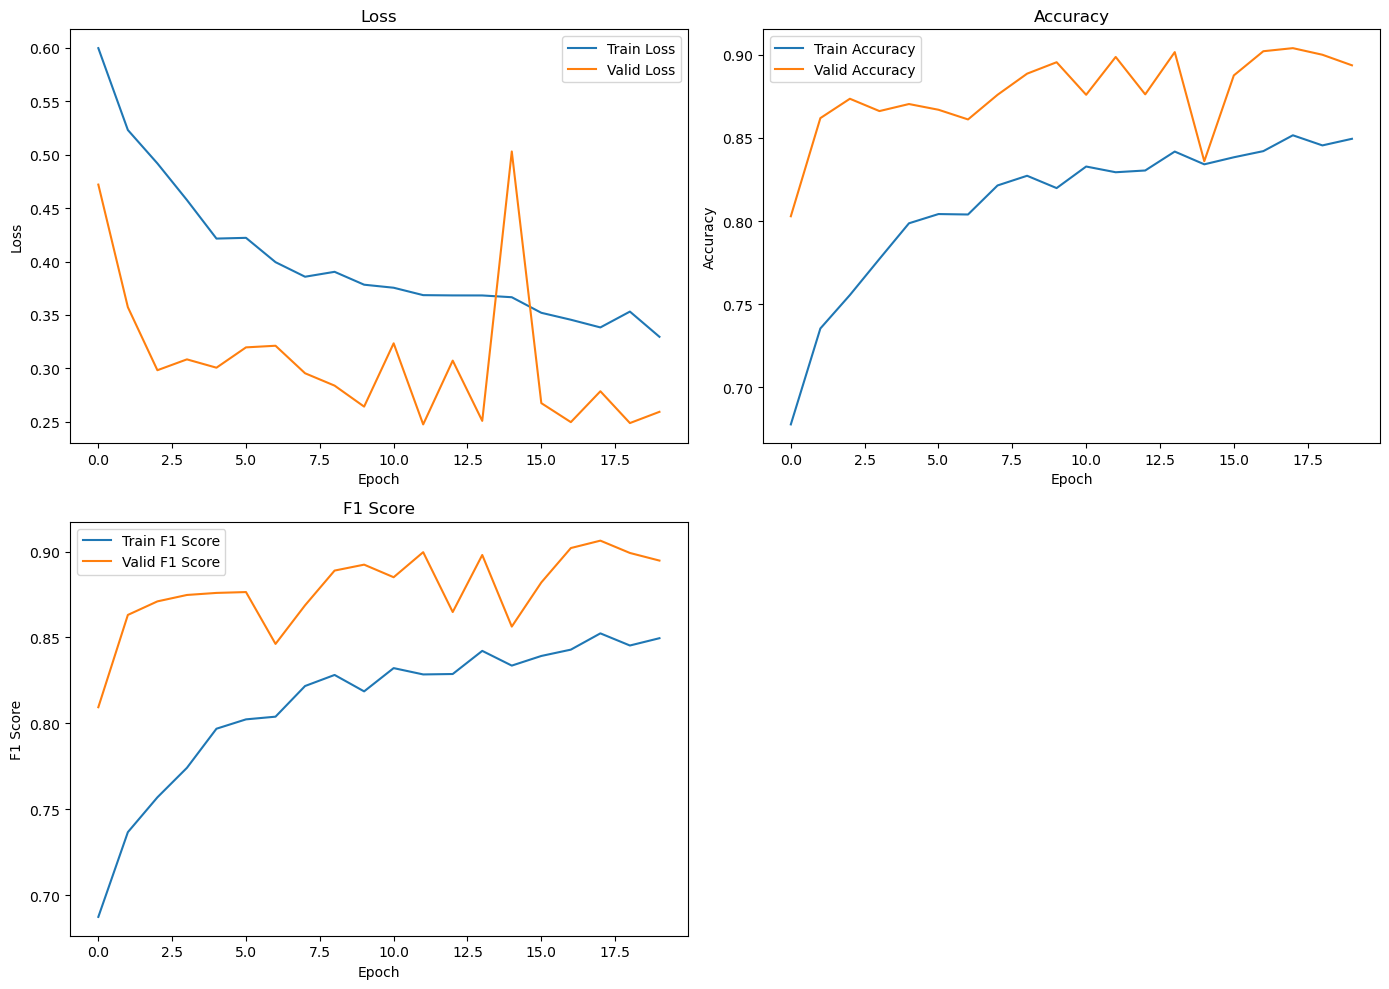

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_directory = f"{root}/model/resnet/"
model = ResNet50Model().to(device)

# Train the model
num_epochs = 20
lr = 0.0001
best_val_file = training.train_model(model, train_loader, valid_loader, model_save_directory, num_epochs=num_epochs, lr=lr)

##  Evaluation

In [15]:
model = ResNet50Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

model.eval() # 評価モードに入る。dropoutは学習にしか使わない。dropoutはノイズを入れている。ノイズに耐えられるように。
with torch.no_grad():
    test_predictions = []
    test_outputs = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
        outputs = model(inputs)
        # _, test_predictions = torch.max(outputs, 1) # outputsの大きい方が選ばれるけど、二値分類なので異なる
        test_outputs.append(outputs)
        test_predictions.extend(1 if x >= 0.5 else 0 for x in outputs) # Appendは１つ、extendは複数
        
df_test["predictions"] = test_predictions

In [16]:
training.test_classification_report(df_test)
df_test.to_csv(f"../../dataset/AAAI 2025/{db}/evaluation/df_test_resnet.csv", index=False)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2378
           1       0.93      0.86      0.89      2409

    accuracy                           0.90      4787
   macro avg       0.90      0.90      0.90      4787
weighted avg       0.90      0.90      0.90      4787

Skin tone 3: Accuracy 0.9235993208828522
Skin tone 0: Accuracy 0.8991803278688525
Skin tone 1: Accuracy 0.9200343938091143
Skin tone 2: Accuracy 0.8417618270799347
